In [1]:
import asyncio
import urllib.request, json
import websockets
import pandas as pd
import nest_asyncio
import numpy as np
import datetime as dt
from scipy import interpolate
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D

In [2]:
nest_asyncio.apply()

In [3]:
def make_dataframe(url, param, index_name):
    #takes url for given deribit method we want to get and makes into a data frame
    #we do this in the notebook since jupyter takes up a thread for asyncio and 
    #I don't know how to fix that by using multithreaded stuff yet
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.DataFrame(data[param]).set_index(index_name)
    return data

In [4]:
make_dataframe("https://test.deribit.com/api/v2/public/get_book_summary_by_currency?currency=BTC&kind=future", 'result', 'instrument_name')

,volume_usd,volume,quote_currency,price_change,open_interest,mid_price,mark_price,low,last,high,estimated_delivery_price,creation_timestamp,bid_price,base_currency,ask_price,funding_8h,current_funding
instrument_name,,,,,,,,,,,,,,,,,
BTC-19FEB21,4.662034e+07,980.56,USD,7.9067,7949620,48761.00,48801.91,44329.50,48749.00,49175.5,48356.63,1613089739111,48749.0,BTC,48773.0,NaN,NaN
BTC-25JUN21,1.244170e+07,253.45,USD,5.4549,113012170,NaN,49874.86,47343.00,49925.50,50000.0,48356.63,1613089739111,49924.0,BTC,NaN,NaN,NaN
BTC-13FEB21,1.000000e+01,0.00,USD,0.0000,0,47198.50,47140.36,47191.00,47191.00,47191.0,48356.63,1613089739111,47191.0,BTC,47206.0,NaN,NaN
BTC-31DEC21,0.000000e+00,0.00,USD,NaN,0,NaN,48356.63,NaN,NaN,NaN,48356.63,1613089739111,52301.0,BTC,NaN,NaN,NaN
BTC-12FEB21,4.520480e+06,98.85,USD,2.7104,38116770,45937.75,45888.34,44726.72,45938.98,46032.5,48356.63,1613089739111,45893.0,BTC,45982.5,NaN,NaN
BTC-26FEB21,1.812680e+06,38.80,USD,7.0297,6863460,47380.00,48251.86,45130.00,48302.50,48539.5,48356.63,1613089739111,44996.5,BTC,49763.5,NaN,NaN
BTC-26MAR21,8.124620e+06,167.52,USD,9.2316,382538980,49951.25,49899.86,45587.00,49950.50,50672.5,48356.63,1613089739111,49950.5,BTC,49952.0,NaN,NaN
BTC-24SEP21,1.248264e+07,251.02,USD,2.9525,253261920,NaN,52968.00,49051.00,50648.50,50648.5,48356.63,1613089739111,53021.0,BTC,NaN,NaN,NaN
BTC-PERPETUAL,1.129141e+09,24219.53,USD,8.0230,1909603126,48435.50,48417.42,44019.00,48433.00,49094.5,48356.63,1613089739111,48433.0,BTC,48438.0,0.000576,0.000757


In [5]:
msg = \
    {"jsonrpc": "2.0",
     "method": "public/subscribe",
     "id": 42,
     "params": {
        "channels": ["markprice.options.btc_usd"]}
    }

async def call_api(msg):
    async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
       await websocket.send(msg)
       while websocket.open:
           response = await websocket.recv()
           data = response
           data = json.loads(data)
           #used_list = [i for i in data['params']]
           #used_list = pd.DataFrame.from_records(used_list)
           #data.keys()
           from pandas.io.json import json_normalize
           #data_normalized = json_normalize(data)
           if('result' in data):
               pass
           else:
               data_norm = json_normalize(data['params']['data'])
               print(data_norm)
               #await websocket.close()
               await websocket.close()
               return data_norm 
                
                
           #data = pd.io.json.json_normalize(response, record_path = [['params', 'data']])
           #data = pd.json_normalize(data)
           #data = pd.DataFrame(data['result']).set_index('instrument_name')
           print("\n\n")
           # do something with the notifications...

In [6]:
data = asyncio.get_event_loop().run_until_complete(call_api(json.dumps(msg)))




     mark_price        iv      instrument_name  synthetic_future.mark_price  \
0      0.160870  1.000000  BTC-24SEP21-40000-P                          NaN   
1      0.025540  1.000000   BTC-5MAR21-40000-P                 48707.949988   
2      0.122579  0.499327   BTC-5MAR21-54000-P                 48707.949988   
3      0.003692  2.318410  BTC-26MAR21-11000-P                          NaN   
4      0.092960  1.000000  BTC-25JUN21-36000-P                          NaN   
..          ...       ...                  ...                          ...   
489    0.221686  1.715210  BTC-19FEB21-39000-C                          NaN   
490    0.382358  2.500001  BTC-26FEB21-32000-C                          NaN   
491    0.087002  1.000000  BTC-26FEB21-49000-P                          NaN   
492    0.816836  1.188996  BTC-24SEP21-10000-C                          NaN   
493    0.005463  1.188996  BTC-24SEP21-10000-P                          NaN   

    synthetic_future.instrument_name  
0        

/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [7]:
data.head()

,mark_price,iv,instrument_name,synthetic_future.mark_price,synthetic_future.instrument_name
0,0.160870,1.000000,BTC-24SEP21-40000-P,NaN,NaN
1,0.025540,1.000000,BTC-5MAR21-40000-P,48707.949988,SYN.BTC-5MAR21
2,0.122579,0.499327,BTC-5MAR21-54000-P,48707.949988,SYN.BTC-5MAR21
3,0.003692,2.318410,BTC-26MAR21-11000-P,NaN,NaN
4,0.092960,1.000000,BTC-25JUN21-36000-P,NaN,NaN


In [8]:
def filter_options(data, price):
    data['strike'] = data.instrument_name.str.split("-").apply(lambda x:x[2])
    data['exp'] = data.instrument_name.str.split("-").apply(lambda x:x[1])
    data['type'] = data.instrument_name.str.split("-").apply(lambda x:x[3])
    data['time'] = (pd.to_datetime(data['exp'])-pd.Timestamp.today()).dt.days
    data['moneyness'] = np.log(data['strike'].astype('float')/price)
    return data 

In [9]:
def get_tick_data(instrument_name):
    import urllib.request, json
    url =  f"https://test.deribit.com/api/v2/public/ticker?instrument_name={instrument_name}"
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
    data = pd.json_normalize(data['result'])
    data.index = [instrument_name]
    return data

In [15]:
 price = get_tick_data('BTC-PERPETUAL')

In [16]:
def get_option_data():
    price = get_tick_data('BTC-PERPETUAL')
    filter_options(data, price['last_price'][0])
    for i in options.iloc[:, 2]:
        price = price.append(get_tick_data(i))
    return price

In [17]:
options = filter_options(data, price['last_price'][0])

In [18]:
option_data = get_option_data()

In [19]:
option_data.loc[1:,'time'] = (pd.to_datetime(option_data[1:].index.map(lambda x: x.split('-')[1]))-pd.Timestamp.today()).days
option_data.loc[1:,'strike'] = option_data[1:].index.map(lambda x: x.split('-')[2]).astype(int)
option_data['moneyness'] = np.log(option_data['last_price'][0]/option_data['strike'])

/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """Entry point for launching an IPython kernel.
/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  


In [20]:
def plot_iv_surf(x,y,z,x2=None,y2=None,z2=None,label=''):
    fig = plt.figure(3, figsize=(10,10))
    ax=plt.axes(projection='3d')
    ax.set_title('Bitcoin Implied Volatility Surface')
    ax.set_zlabel('Implied Volatility')
    plt.xlabel('Strike')
    plt.ylabel('Days To Expiration')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda z, _: '{:.0%}'.format(z)))
    if z2 is not None:
        ax.scatter3D(x2,y2,z2, c='r', s=100,label=label)
    ax.plot_surface(x, y, z, rstride=1, cstride=1,alpha=0.5)
    ax.legend()

/home/tjang/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


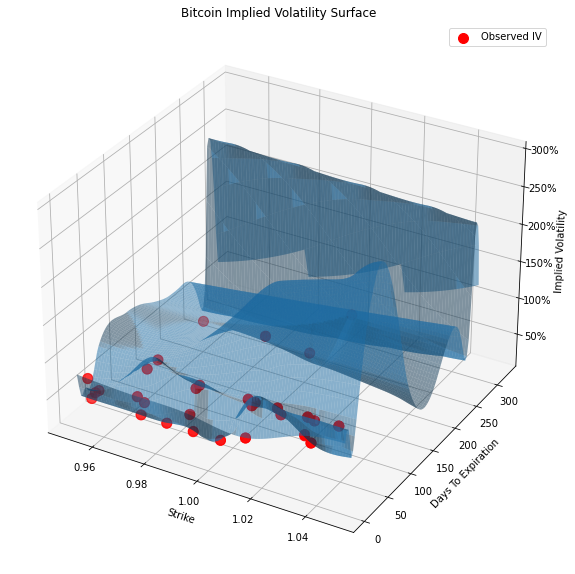

In [21]:
option_data_ = option_data.iloc[1:].sort_values(['time','strike']).query('time>0')
x = (option_data['last_price'][0]/option_data_['strike'])
y = option_data_['time']
z = option_data_['mark_iv']/100

X,Y = np.meshgrid(np.linspace(.95,1.05,99),np.linspace(1,np.max(y),100))
Z = interpolate.griddata(np.array([x,y]).T,np.array(z),(X,Y), method='cubic')

xyz = pd.DataFrame({'x':x,'y':y,'z':z})
xyz = xyz.query('x>0.95 & x<1.05')
plot_iv_surf(X,Y,Z,xyz['x'],xyz['y'],xyz['z'],'Observed IV')

iv_df = pd.DataFrame(Z, index=np.linspace(10,np.max(y),100), columns=np.linspace(.95,1.05,99))